To run this notebook, load it in a local Jupyter instance (`pip install jupyter`). You'll also need these dependencies:

```
pip install tf-nightly
pip install google-cloud-storage
pip install requests
pip install google-api-python-client
```

You may also need to run this if you're not inside a google cloud VM:

```
gcloud auth application-default login
```

You need to configure [OAuth](https://support.google.com/cloud/answer/6158849?hl=en). It's a complicated process, best described [here](https://github.com/googleapis/google-api-python-client/blob/master/docs/client-secrets.md). In the end you donwload the `client_secrets.json` file and use it below.

In [342]:
import argparse
from astronet import tune_vetting
from astronet import train

config_name = 'vrevised'

tune_vetting.FLAGS = tune_vetting.parser.parse_args([
  '--client_secrets', '../client_secrets.json',
  '--model', 'AstroCnnModelVetting',
  '--config_name', config_name,
  '--train_files', '',
])
train.FLAGS = train.parser.parse_args([
  '--model', 'AstroCnnModelVetting',
  '--config_name', config_name,
  '--train_files', '',
])


# client = tune_vetting.initialize_client()

In [343]:
import pandas as pd

pd.set_option('max_colwidth', 100)

resp = client.projects().locations().studies().list(
    parent=tune_vetting.study_parent()).execute()
studies = pd.DataFrame(resp['studies'])
studies = studies.sort_values('createTime', ascending=False)
studies.head(5)

,name,state,createTime
0,projects/889849304565/locations/us-central1/studies/5_vrevised_3_vrevised,ACTIVE,2021-10-13T13:01:07Z
1,projects/889849304565/locations/us-central1/studies/5_vrevised_2_vrevised,ACTIVE,2021-10-13T12:43:24Z
2,projects/889849304565/locations/us-central1/studies/5_vrevised_1_vrevised,ACTIVE,2021-10-13T02:41:42Z
3,projects/889849304565/locations/us-central1/studies/vtest210_vrevised,ACTIVE,2021-10-13T02:39:44Z
4,projects/889849304565/locations/us-central1/studies/30_revised_1c_revised,ACTIVE,2021-10-12T14:52:37Z


In [344]:
study = studies['name'][0]
study_id = '{}/studies/{}'.format(tune_vetting.study_parent(), study.split('/')[-1])
print(study_id)
resp = client.projects().locations().studies().trials().list(parent=study_id).execute()

metrics_loss = []
params = []
trial_ids = []
for trial in resp['trials']:
  if 'finalMeasurement' not in trial:
    continue
    
  if 'value' not in trial['finalMeasurement']['metrics'][0]:
    continue

  loss, = (m['value'] for m in trial['finalMeasurement']['metrics'] if m['metric'] == 'loss')  
  
  params.append(trial['parameters'])
  metrics_loss.append(loss)
  trial_ids.append(int(trial['name'].split('/')[-1]))
  
print(max(trial_ids), 'total studies')
print(len(trial_ids), 'valid studies')

projects/mdan-playground/locations/us-central1/studies/5_vrevised_3_vrevised
102 total studies
97 valid studies


27 0.19154800474643707
51 0.1876561939716339
81 0.18820832669734955
91 0.18887677788734436
101 0.1868777573108673
Best trial: 101


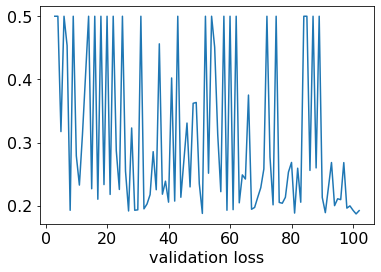

In [345]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams.update({'font.size': 16})

fig, ax = plt.subplots()
ax.plot(trial_ids, np.minimum(metrics_loss, 0.5))
plt.xlabel("validation loss")
sorted_metrics = sorted(metrics_loss, reverse=True)

best = 0
for i, trial_id in enumerate(trial_ids):
  if (metrics_loss[i] <= sorted_metrics[-5]):
    print(trial_ids[i], metrics_loss[i])
  if (metrics_loss[i] <= metrics_loss[best]):
    best = i

print('Best trial:', trial_ids[best])

Best so far: `projects/mdan-playground/locations/us-central1/studies/4_vrevised_1_vrevised` (89 - 0.0820508822798729)

In [346]:
import pprint
from astronet import models

config = models.get_model_config('AstroCNNModelVetting', config_name)

for param in params[best]:
  tune_vetting.map_param(config['hparams'], config['vetting_hparams'], param, config['inputs'])

print(train.FLAGS.train_steps)
pprint.pprint(config['vetting_hparams'])
pprint.pprint(config['hparams'])

13626
{'aux_inputs': [],
 'num_pre_logits_hidden_layers': 0,
 'pre_logits_dropout_rate': 0,
 'pre_logits_hidden_layer_size': 63,
 'time_series_hidden': {'local_aperture_s': {'cnn_block_filter_factor': 1.9982274277978687,
                                             'cnn_block_size': 2,
                                             'cnn_initial_num_filters': 127,
                                             'cnn_kernel_size': 6,
                                             'cnn_num_blocks': 1,
                                             'convolution_padding': 'same',
                                             'extra_channels': ['local_aperture_m',
                                                                'local_aperture_l'],
                                             'pool_size': 1,
                                             'pool_strides': 5,
                                             'separable': False}},
 'use_batch_norm': False}
{'adam_epsilon': 1.3610394209274906e-08,

In [347]:
import difflib
import pprint
from astronet import models

config1 = models.get_model_config('AstroCNNModelVetting', config_name)

config2 = models.get_model_config('AstroCNNModelVetting', config_name)
for param in params[best]:
  tune_vetting.map_param(config2['hparams'], config2['vetting_hparams'], param, config2.inputs)
  
pp = pprint.PrettyPrinter()
print('\n'.join(difflib.unified_diff(
  pp.pformat(config1).split('\n'), pp.pformat(config2).split('\n'),
  n=0
)))

--- 

+++ 

@@ -1 +1 @@

-{'hparams': {'adam_epsilon': 1e-07,
+{'hparams': {'adam_epsilon': 1.3610394209274906e-08,
@@ -23,2 +23,2 @@

-             'batch_size': 100,
-             'learning_rate': 1e-05,
+             'batch_size': 427,
+             'learning_rate': 2.255006500344329e-06,
@@ -26,2 +26,2 @@

-             'one_minus_adam_beta_1': 0.1,
-             'one_minus_adam_beta_2': 0.0,
+             'one_minus_adam_beta_1': 0.15155284987537607,
+             'one_minus_adam_beta_2': 0.03949233982314313,
@@ -295,9 +295,9 @@

-                     'num_pre_logits_hidden_layers': 3,
-                     'pre_logits_dropout_rate': 0.1,
-                     'pre_logits_hidden_layer_size': 256,
-                     'time_series_hidden': {'local_aperture_s': {'cnn_block_filter_factor': 2,
-                                                                 'cnn_block_size': 1,
-                                                                 'cnn_initial_num_filters': 8,
-         

```
python astronet/tune_vetting.py --model=AstroCNNModelVetting --config_name=vrevised --train_files=/mnt/tess/astronet/tfrecords-vetting-5-toi-train/* --eval_files=/mnt/tess/astronet/tfrecords-vetting-5-toi-val/* --pretrain_model_dir=/mnt/tess/astronet/checkpoints/revised_tuned_30_run_1 --train_steps=0 --tune_trials=10000 --client_secrets=../client_secrets.json --study_id=5_vrevised_1
```